In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from torchsampler import ImbalancedDatasetSampler
from torch.optim import lr_scheduler

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
# используем враппер над датасетом для удобной работы

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                 transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                 ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [9]:
val_dataset

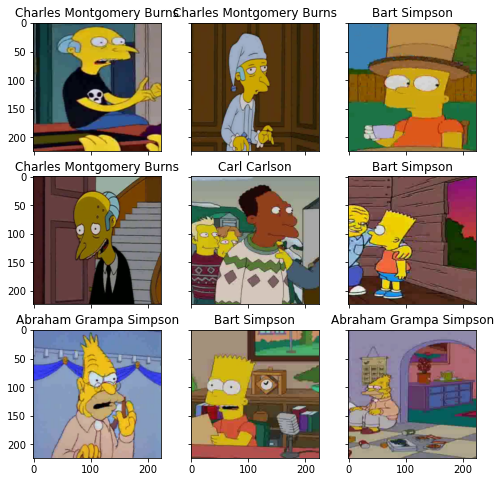

In [10]:
# Посмотрим на наших героев внутри датасета.

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

*Описание слоев*:
1. размерность входа: 3x224x224 
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs, aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4*loss2
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        for epoch in range(epochs):
            
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [15]:
n_classes = len(np.unique(train_val_labels))


In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

####  Обучение

In [16]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=25, batch_size=64)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Подготовка на маленькой сети (AlexNet)

In [ ]:
model_AlexNet = models.alexnet(pretrained=True)

In [ ]:
model_AlexNet

* **Fine Tuning** способ

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_AlexNet.classifier = nn.Linear(num_features, n_classes)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_AlexNet = model_AlexNet.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_AlexNet, epochs=30, batch_size=64)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

* **Feature Extractor** способ:

In [ ]:
model_AlexNet_extractor = models.alexnet(pretrained=True)

In [ ]:
for param in model_AlexNet_extractor.parameters():
    print(param.requires_grad)

In [ ]:
# замораживаем параметры (веса)
for param in model_AlexNet_extractor.parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_AlexNet_extractor.classifier = nn.Linear(num_features, n_classes)

In [ ]:
model_AlexNet_extractor =model_AlexNet_extractor.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_AlexNet_extractor, epochs=30, batch_size=64)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

 **Смешанный** способ:
Мы будем обучать не только последний **fully connected** слой, но и несколько предпоследних

In [ ]:
model__AlexNet_mixed = models.alexnet(pretrained=True)


In [ ]:
model__AlexNet_mixed

In [ ]:
layers_to_unfreeze = 5

In [ ]:
for param in model__AlexNet_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model__AlexNet_mixed.classifier = nn.Linear(num_features,  n_classes)

model__AlexNet_mixed =model__AlexNet_mixed.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model__AlexNet_mixed, epochs=30, batch_size=64)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
torch.save(model__AlexNet_mixed.state_dict(), 'model__AlexNet_mixed.pth')

In [ ]:
model__AlexNet_mixed.load_state_dict(torch.load('model__AlexNet_mixed.pth'))

## Подготовка Inception

In [17]:
model_inception_v3 = models.inception_v3(pretrained=True)
#model_inception_v3.aux_logits=False

In [18]:
for param in model_inception_v3.parameters():
    param.requires_grad = False

In [19]:
# Handle the auxilary net
num_ftrs = model_inception_v3.AuxLogits.fc.in_features
model_inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, n_classes)
# Handle the primary net
num_ftrs = model_inception_v3.fc.in_features
model_inception_v3.fc = nn.Linear(num_ftrs,  n_classes)

print(model_inception_v3)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [20]:
model_inception_v3 = model_inception_v3.to(DEVICE)

In [21]:
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [22]:
#for inputs, labels in train_loader:
       # inputs = inputs.to(DEVICE)
        #labels = labels.to(DEVICE)

In [23]:
#a_aa = model_inception_v3(inputs)

In [24]:
#type(a_aa)
#a_aa

In [25]:
# все изображения будут масштабированы к размеру 299x299 (особенность, так обучался inception)
RESCALE_SIZE = 299

In [ ]:
history = train(train_dataset, val_dataset, model=model_inception_v3, epochs=30, batch_size=64)

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 3.216793076415997


epoch:   3%|██▍                                                                      | 1/30 [03:45<1:48:47, 225.08s/it]


Epoch 001 train_loss: 3.2168     val_loss 1.9312 train_acc 0.3544 val_acc 0.5462
loss 2.290336481119631


epoch:   7%|████▊                                                                    | 2/30 [07:28<1:44:37, 224.19s/it]


Epoch 002 train_loss: 2.2903     val_loss 1.6098 train_acc 0.5193 val_acc 0.6041
loss 2.0218195926612315


epoch:  10%|███████▎                                                                 | 3/30 [11:09<1:40:09, 222.58s/it]


Epoch 003 train_loss: 2.0218     val_loss 1.4192 train_acc 0.5582 val_acc 0.6408
loss 1.8651978986431395


epoch:  13%|█████████▋                                                               | 4/30 [14:51<1:36:19, 222.28s/it]


Epoch 004 train_loss: 1.8652     val_loss 1.3177 train_acc 0.5831 val_acc 0.6576
loss 1.7653769037588227


epoch:  17%|████████████▏                                                            | 5/30 [18:35<1:33:00, 223.21s/it]


Epoch 005 train_loss: 1.7654     val_loss 1.2831 train_acc 0.6017 val_acc 0.6710
loss 1.7085889724342904


epoch:  20%|██████████████▌                                                          | 6/30 [22:20<1:29:29, 223.72s/it]


Epoch 006 train_loss: 1.7086     val_loss 1.2303 train_acc 0.6080 val_acc 0.6731
loss 1.6528084607054165


epoch:  23%|█████████████████                                                        | 7/30 [26:06<1:26:03, 224.50s/it]


Epoch 007 train_loss: 1.6528     val_loss 1.2045 train_acc 0.6114 val_acc 0.6758
loss 1.5495482116711732


epoch:  27%|███████████████████▍                                                     | 8/30 [29:53<1:22:33, 225.14s/it]


Epoch 008 train_loss: 1.5495     val_loss 1.1530 train_acc 0.6351 val_acc 0.6977
loss 1.5372705181978852


epoch:  30%|█████████████████████▉                                                   | 9/30 [33:39<1:18:55, 225.51s/it]


Epoch 009 train_loss: 1.5373     val_loss 1.1390 train_acc 0.6402 val_acc 0.7000
loss 1.5265513078309418


epoch:  33%|████████████████████████                                                | 10/30 [37:24<1:15:05, 225.30s/it]


Epoch 010 train_loss: 1.5266     val_loss 1.1405 train_acc 0.6423 val_acc 0.6998
loss 1.528879338210157


epoch:  37%|██████████████████████████▍                                             | 11/30 [41:08<1:11:14, 224.98s/it]


Epoch 011 train_loss: 1.5289     val_loss 1.1382 train_acc 0.6391 val_acc 0.7021


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

 ###   ИТОГ:

In [ ]:
model_current=model_inception_v3

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_current, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_current, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
actual_labels

In [ ]:
preds_class

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_current, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_current, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
len(preds)

In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('simpsons_simple_cnn_baseline.csv', index=False)

In [ ]:
df.head()